In [1]:
# General imports 
import os 
import sys
import logging
import platform
from os.path import join as pjoin
import re
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats 
from skimage import measure
import matplotlib.pyplot as plt

# Pynwb imports
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

In [2]:
sys.path.insert(0,'/code/src')
from bci.loaders import load
from bci.thresholds.thresholds import align_thresholds

In [3]:
logging.basicConfig(
    format="%(asctime)s | %(message)s ",
    datefmt="%d/%m/%Y %I:%M:%S %p",
    level=logging.INFO,
)

In [4]:
# set data path
platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_dir = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_dir = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_dir = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_dir = "/media/$USERNAME/Brain2025/"
    
print('data directory set to', data_dir)

data directory set to /data/


In [5]:
# Load metadata csv file as pandas dataframe
# Metadata contains one mice per row
metadata = pd.read_csv(os.path.join(data_dir, 'bci_task_metadata', 'bci_metadata.csv'))
# Get all mice available
subject_ids = np.sort(metadata['subject_id'].unique())

In [44]:
# Select one mice
n_subjects = len(subject_ids)
subject_id =754303# subject_ids[0]#754303
# Select one subject metadata, sorted by 'session_number'
this_mouse_metadata = metadata[metadata['subject_id']==subject_id].sort_values(by='session_number')
# Pick one session for this mouse
session_name = this_mouse_metadata.name.values[2]
print('Selected subject is', subject_id)
print('Selected session is', session_name)

Selected subject is 754303
Selected session is single-plane-ophys_754303_2025-01-27_20-01-31_processed_2025-08-07_06-00-10


In [45]:
nwbfile = load.load_nwb_session_file(session_name)

BCI data directory: /data/brain-computer-interface

Session directory: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-27_20-01-31_processed_2025-08-07_06-00-10

NWB file: single-plane-ophys_754303_2025-01-27_20-01-31_behavior_nwb
NWB path: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-27_20-01-31_processed_2025-08-07_06-00-10/single-plane-ophys_754303_2025-01-27_20-01-31_behavior_nwb


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Look at the conditions in this dataset

In [46]:
# Load the epochs table from the NWB file
epoch_table = nwbfile.intervals["epochs"].to_dataframe()

In [47]:
# Read traces
dff_traces = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data
print('dff shape (nframes, nrois):',np.shape(dff_traces))
frame_rate = nwbfile.imaging_planes["processed"].imaging_rate
print('Frame Rate:', frame_rate)

dff shape (nframes, nrois): (231103, 2935)
Frame Rate: 58.2634


In [48]:
epoch_table = nwbfile.intervals["epochs"].to_dataframe()

In [49]:
# read trials
bci_trials = nwbfile.stimulus["Trials"].to_dataframe()
# Let's load the thresholds!
thresholds = load.load_session_thresh_file(session_name)
# Align thresholds with bci trials df
bci_trials = align_thresholds(bci_trials=bci_trials, thresholds=thresholds)

All threshold files for mouse 754303: ['single-plane-ophys_754303_2025-01-27', 'single-plane-ophys_754303_2025-01-23', 'single-plane-ophys_754303_2025-01-29', 'single-plane-ophys_754303_2025-01-31', 'single-plane-ophys_754303_2025-02-03']

Found threshold file at: /data/bci-thresholds/single-plane-ophys_754303_2025-01-27
total difference in dataframes: 5


In [50]:
# Get just the BCI epochs
BCI_epochs = epoch_table[epoch_table.stimulus_name.str.contains('BCI')]

In [51]:
# Get correct trials
correct_bci_trials = bci_trials[bci_trials['hit']==True]
# Select trials where there is information about threshold
correct_bci_trials = correct_bci_trials[correct_bci_trials['low'].notna()]
correct_bci_trials.dropna(inplace=True,subset=['start_time', 'stop_time','threshold_crossing_times'])
correct_bci_trials=correct_bci_trials.reset_index()

In [52]:
start_bci_epoch = BCI_epochs.loc[BCI_epochs.index[0]].start_frame
stop_bci_epoch = BCI_epochs.loc[BCI_epochs.index[0]].stop_frame
start_bci_trial = correct_bci_trials['start_frame']-start_bci_epoch
stop_bci_trial = correct_bci_trials['stop_frame']-start_bci_epoch
thrcrossframe_bci_trial = np.round(correct_bci_trials['threshold_crossing_times']*frame_rate).astype(int)
zaber_steps = np.round(np.array(correct_bci_trials['zaber_step_times'].tolist())*frame_rate)
go_cue_bci = np.round(correct_bci_trials['go_cue']*frame_rate).astype(int)
reward_time = np.round(correct_bci_trials['reward_time']*frame_rate).astype(int)

In [53]:
low_thres =correct_bci_trials.low
high_thres =correct_bci_trials.high

### Read traces

In [54]:
# # Get the dFF traces from the NWB file
# dff_traces = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data
# # Look at the shape - the larger dimension are the 2P frames
# print(dff_traces.shape)

In [55]:
# Index into the dff traces array to limit to the relevant time points
dff_bci = dff_traces[start_bci_epoch:stop_bci_epoch, :]
# Now transpose so rows are ROI IDs
dff_bci = dff_bci.T
print(dff_bci.shape) # ROI by time

(2935, 59481)


In [56]:
# Get the roi_table from the NWB file
roi_table = nwbfile.processing["processed"].data_interfaces["image_segmentation"].plane_segmentations["roi_table"].to_dataframe()

In [57]:
# Remove ROIs with traces that are NaNs (note - this takes a few seconds)
valid_trace_ids = [i for i in range(dff_traces.shape[1]) if np.isnan(dff_traces[0, i])==False]
# Limit ROI table to non-NaN traces
roi_table2 = roi_table.loc[valid_trace_ids]

In [58]:
# Find the likely somatic ROIs
soma_probability = 0.005 # Emperically determined threshold - just trust us
# Limit to valid somatic ROIs
valid_rois = roi_table2[roi_table2.soma_probability>soma_probability]

In [59]:
# Find the likely somatic ROIs
soma_probability = 0.005 # Emperically determined threshold - just trust us
# Limit to valid somatic ROIs
valid_rois = roi_table2[roi_table2.soma_probability>soma_probability]
target_roi_idx = bci_trials['closest_roi'].unique()
print(f"CN: {target_roi_idx}")
if len(target_roi_idx)>1:
    raise ValueError("More than one CN during BCI epoch")
target_roi_idx=target_roi_idx[0]
if not(target_roi_idx in valid_rois.index):
    valid_rois = pd.concat((valid_rois, roi_table2.loc[[target_roi_idx], :]), axis=0)
    valid_rois = valid_rois.sort_index()
print('there are', len(valid_rois), 'ROIs with soma_probability >',soma_probability)

CN: [33]
there are 176 ROIs with soma_probability > 0.005


In [60]:
# Limit dff traces for spontaneous activity period before the task to valid ROIs
dff_bci_valid = dff_bci[valid_rois.index.values, :]
print(dff_bci_valid.shape)

(176, 59481)


In [61]:
roi_original_idx = valid_rois.reset_index()['id']
cn_new_idx = roi_original_idx[roi_original_idx==target_roi_idx].index[0]

Text(0.5, 1.0, 'BCI')

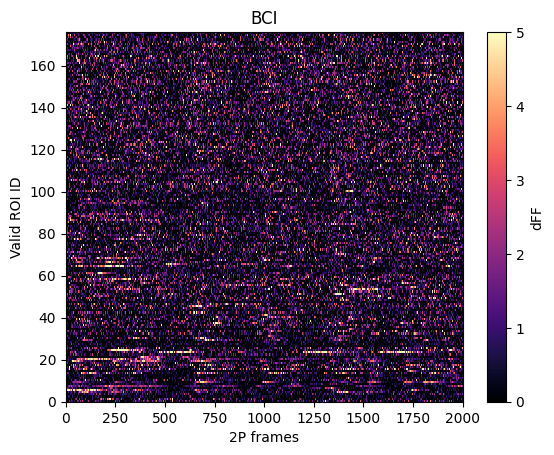

In [62]:
plt.pcolormesh(dff_bci_valid[:,:2000], vmin=0, vmax=5, cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('Valid ROI ID')
plt.title('BCI')

In [63]:
frame_rate

np.float64(58.2634)

In [64]:
# Smooth dff
smoothing_window = 10
smooth_dff_valid = np.full(dff_bci_valid.shape,np.nan)
kernel = np.ones(smoothing_window) / smoothing_window
for itr,trial in enumerate (dff_bci_valid):
    smooth_dff_valid[itr] = np.convolve(trial, kernel, mode='same')

In [65]:
target_roi_idx

np.int64(33)

[Text(0, 19, 'CN')]

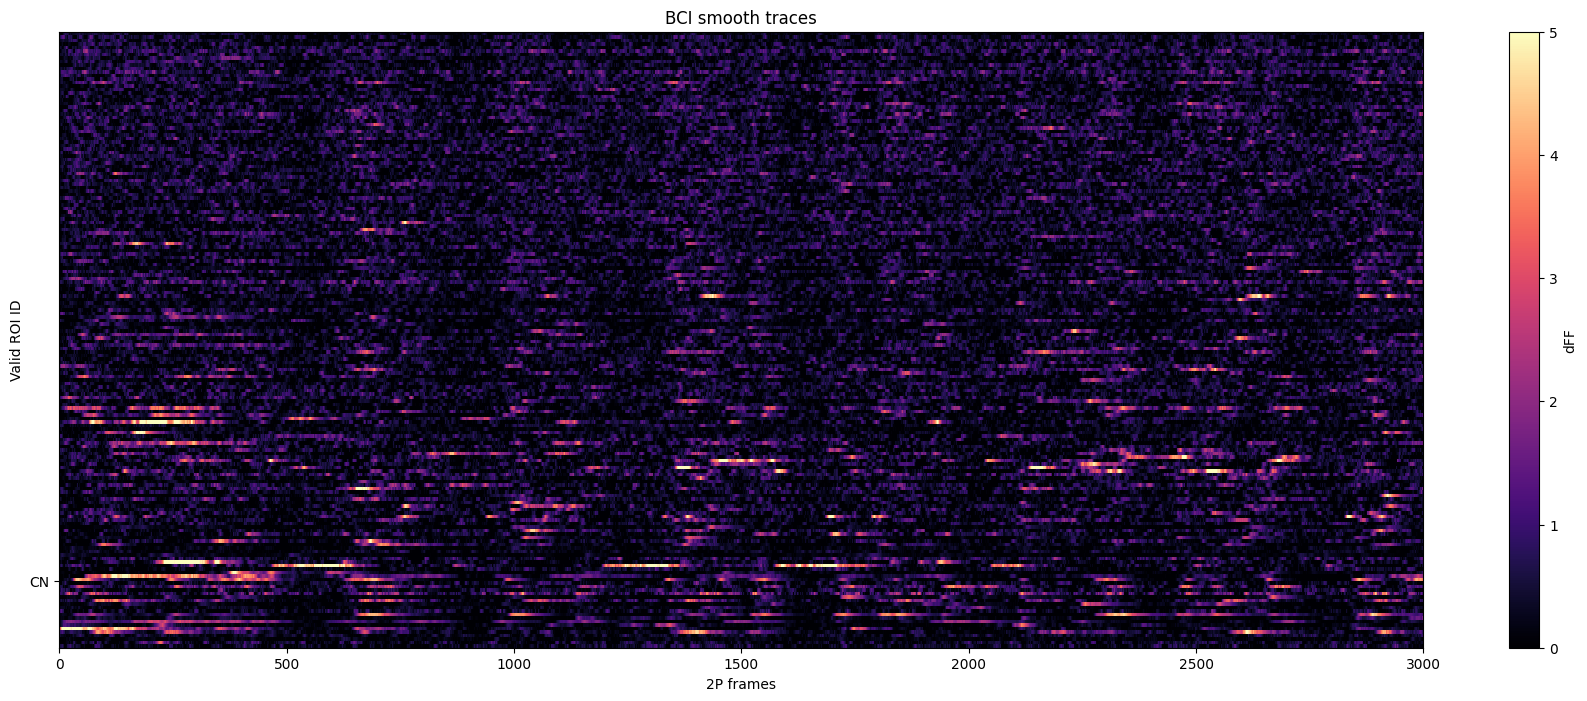

In [66]:
fig,ax=plt.subplots(figsize=(22,8))
plt.pcolormesh(smooth_dff_valid[:,:3000], vmin=0, vmax=5, cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('Valid ROI ID')
plt.title('BCI smooth traces')
ax.set_yticks([cn_new_idx])
ax.set_yticklabels(['CN'])

In [67]:
# Organize data by trials
n_rois = smooth_dff_valid.shape[0]
n_trials = len(start_bci_trial)
max_tr_duration = np.max(stop_bci_trial-start_bci_trial)
dff_by_trial = np.full((n_rois,n_trials,max_tr_duration*2),np.nan)
for itr,(ist,istp) in enumerate(zip(start_bci_trial,stop_bci_trial)):

    dff_by_trial[:,itr,:int(istp-ist)] = smooth_dff_valid[:,ist:istp]

In [68]:
dff_by_trial.shape

(176, 84, 1822)

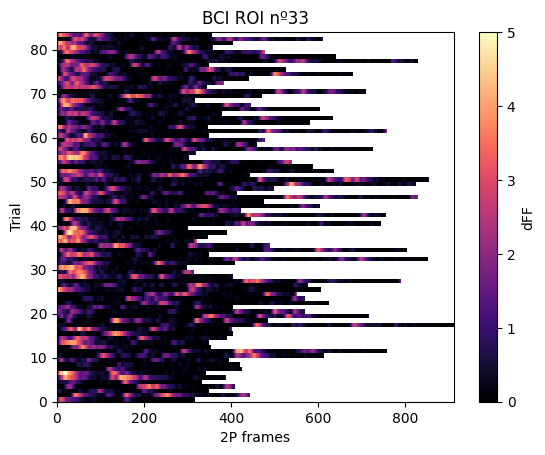

In [69]:
i_roi = cn_new_idx
original_roi = roi_original_idx.loc[i_roi]
plt.pcolormesh(dff_by_trial[i_roi,:,:max_tr_duration], vmin=0, vmax=5, cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('Trial')
plt.title(f'BCI ROI nº{original_roi}')
ax.set_yticks(roi_original_idx[roi_original_idx==target_roi_idx].index)

In [70]:
def indep_roll(
    arr: np.ndarray, shifts: np.ndarray, axis: int = 1
) -> np.ndarray:
    """Apply an independent roll for each dimensions of a single axis.
    Args:
        arr (np.ndarray): Array of any shape.
        shifts (np.ndarray): How many shifting to use for each dimension. Shape: `(arr.shape[axis],)`.
        axis (int, optional): Axis along which elements are shifted. Defaults to 1.

    Returns:
        np.ndarray: shifted array.
    """
    arr = np.swapaxes(
        arr, axis, -1
    )  # Move the target axis to the last position
    all_idcs = np.ogrid[
        [slice(0, n) for n in arr.shape]
    ]  # Create grid indices
    shifts[shifts < 0] += arr.shape[-1]  # Convert to a positive shift
    new_indices = all_idcs[-1] - shifts[:, np.newaxis]
    result = arr[tuple(all_idcs[:-1]) + (new_indices,)]
    arr = np.swapaxes(result, -1, axis)
    return arr

In [71]:
# Let's align on threshold_crossing_times
frames_before = int(np.max(thrcrossframe_bci_trial.values))
shifts = thrcrossframe_bci_trial.values -frames_before
dff_bci_alignon_thr = indep_roll(dff_by_trial,-shifts,axis=-1)
dff_bci_alignon_thr.shape

(176, 84, 1822)

Text(0.5, 1.0, 'BCI ROI nº33')

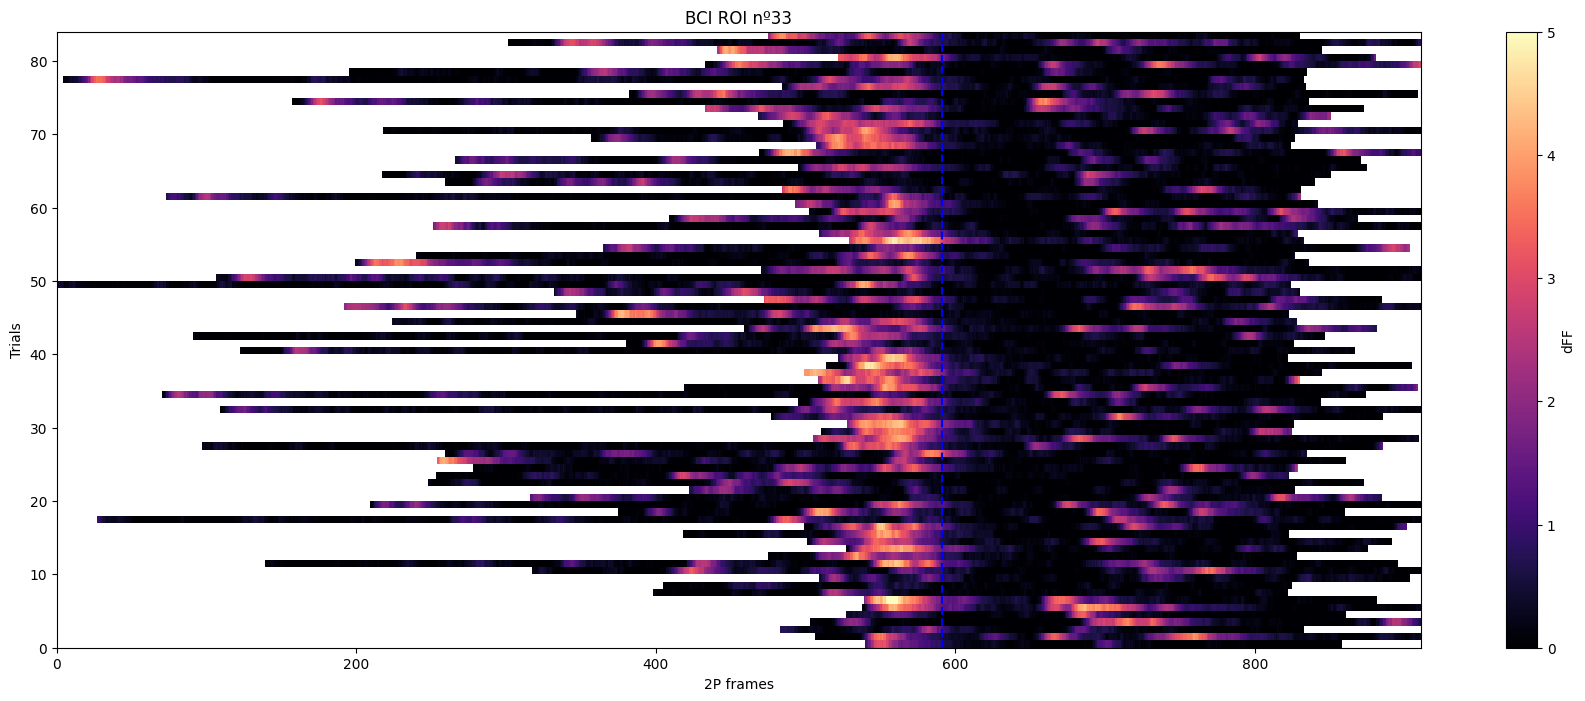

In [72]:
i_roi = cn_new_idx
original_roi = roi_original_idx.loc[i_roi]
fig,ax=plt.subplots(figsize=(22,8))
plt.pcolormesh(dff_bci_alignon_thr[i_roi,:,:max_tr_duration],cmap='magma',vmin=0,vmax=5)
plt.colorbar(label='dFF')
ax.vlines([frames_before],[0],[n_trials],'b',linestyle='--')
plt.xlabel('2P frames')
plt.ylabel('Trials')
plt.title(f'BCI ROI nº{original_roi}')

In [73]:
np.nanmean(dff_bci_alignon_thr,axis=1).shape

/tmp/ipykernel_44842/1038190334.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(dff_bci_alignon_thr,axis=1).shape


(176, 1822)

/tmp/ipykernel_44842/1467065868.py:2: RuntimeWarning: Mean of empty slice
  plt.pcolormesh(np.nanmean(dff_bci_alignon_thr,axis=1)[:,:frames_before+200], cmap='magma',vmin=0,vmax=5)


Text(0.5, 1.0, 'BCI avg')

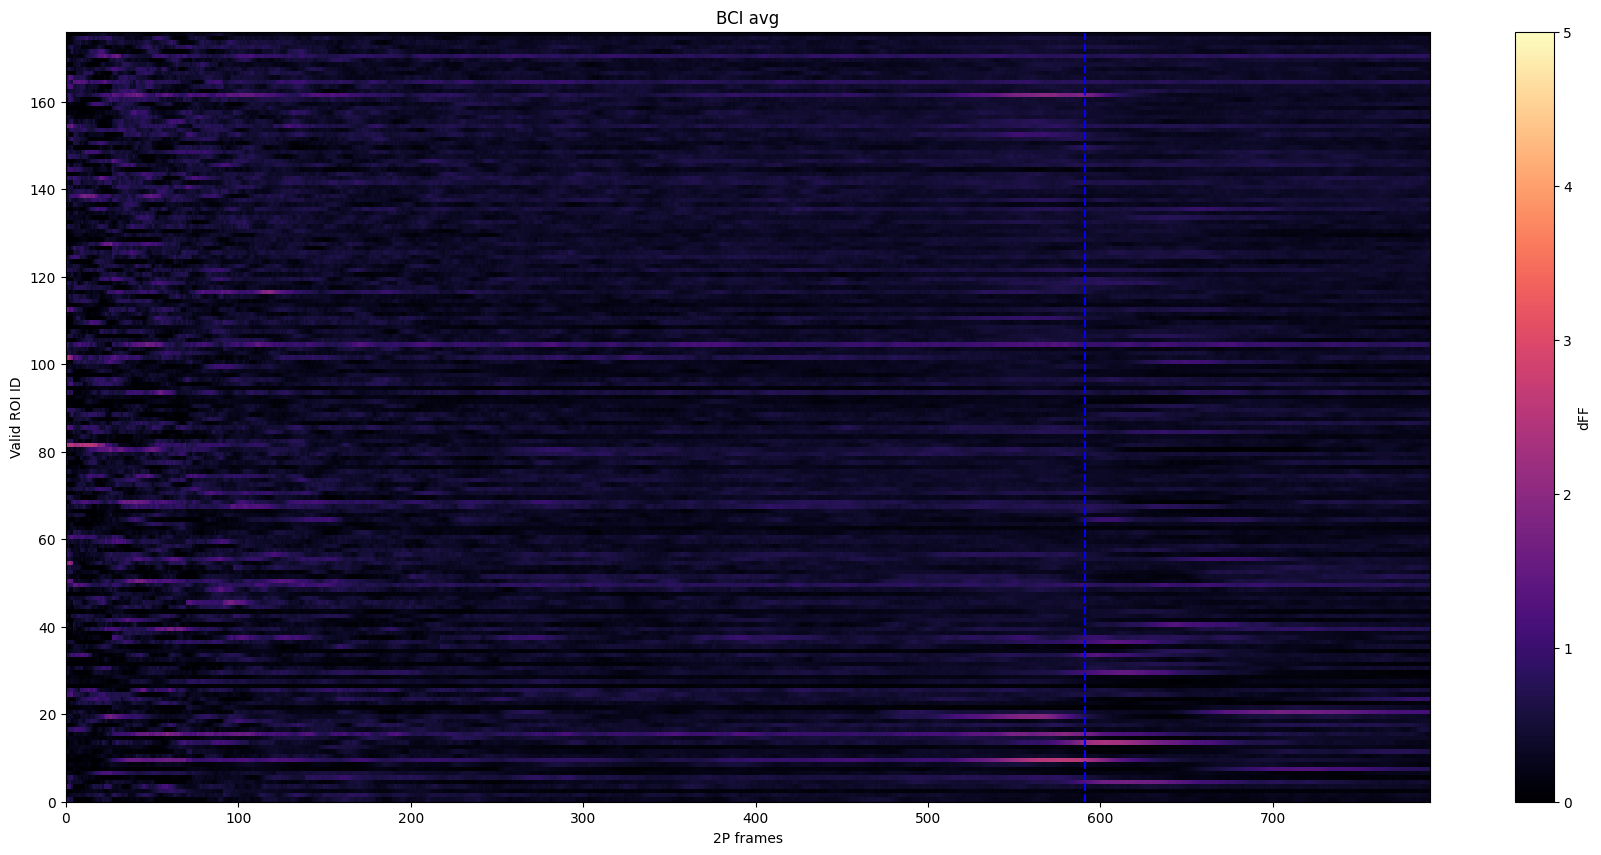

In [74]:
fig,ax=plt.subplots(figsize=(22,10))
plt.pcolormesh(np.nanmean(dff_bci_alignon_thr,axis=1)[:,:frames_before+200], cmap='magma',vmin=0,vmax=5)
plt.colorbar(label='dFF')
ax.vlines([frames_before],[0],[dff_bci_alignon_thr.shape[0]],'b',linestyle='--')
plt.xlabel('2P frames')
plt.ylabel('Valid ROI ID')
plt.title(f'BCI avg')

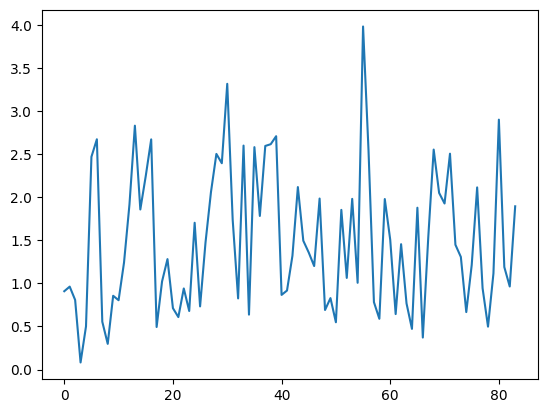

In [75]:
mean_act=[]
for i,i_thr in enumerate(thrcrossframe_bci_trial.values):
   zaber_st = zaber_steps[i]
   zaber_st = zaber_st[~np.isnan(zaber_st)].astype(int)
   selected_activations = [dff_by_trial[i_roi,i,istep] for istep in zaber_st]
   mean_act.append(np.mean(selected_activations))
plt.plot(mean_act)

In [76]:
dff_bci_alignon_thr.shape

(176, 84, 1822)

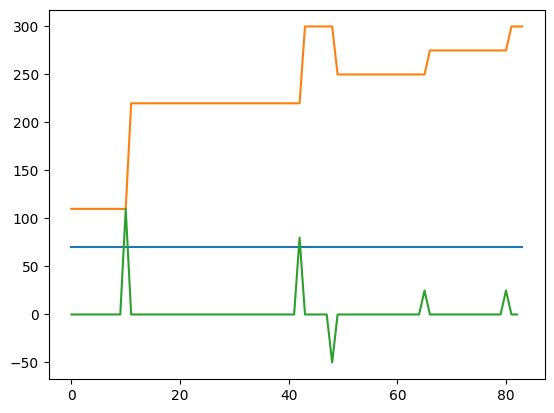

In [77]:
plt.plot(low_thres)
plt.plot(high_thres)
plt.plot(np.diff(high_thres))

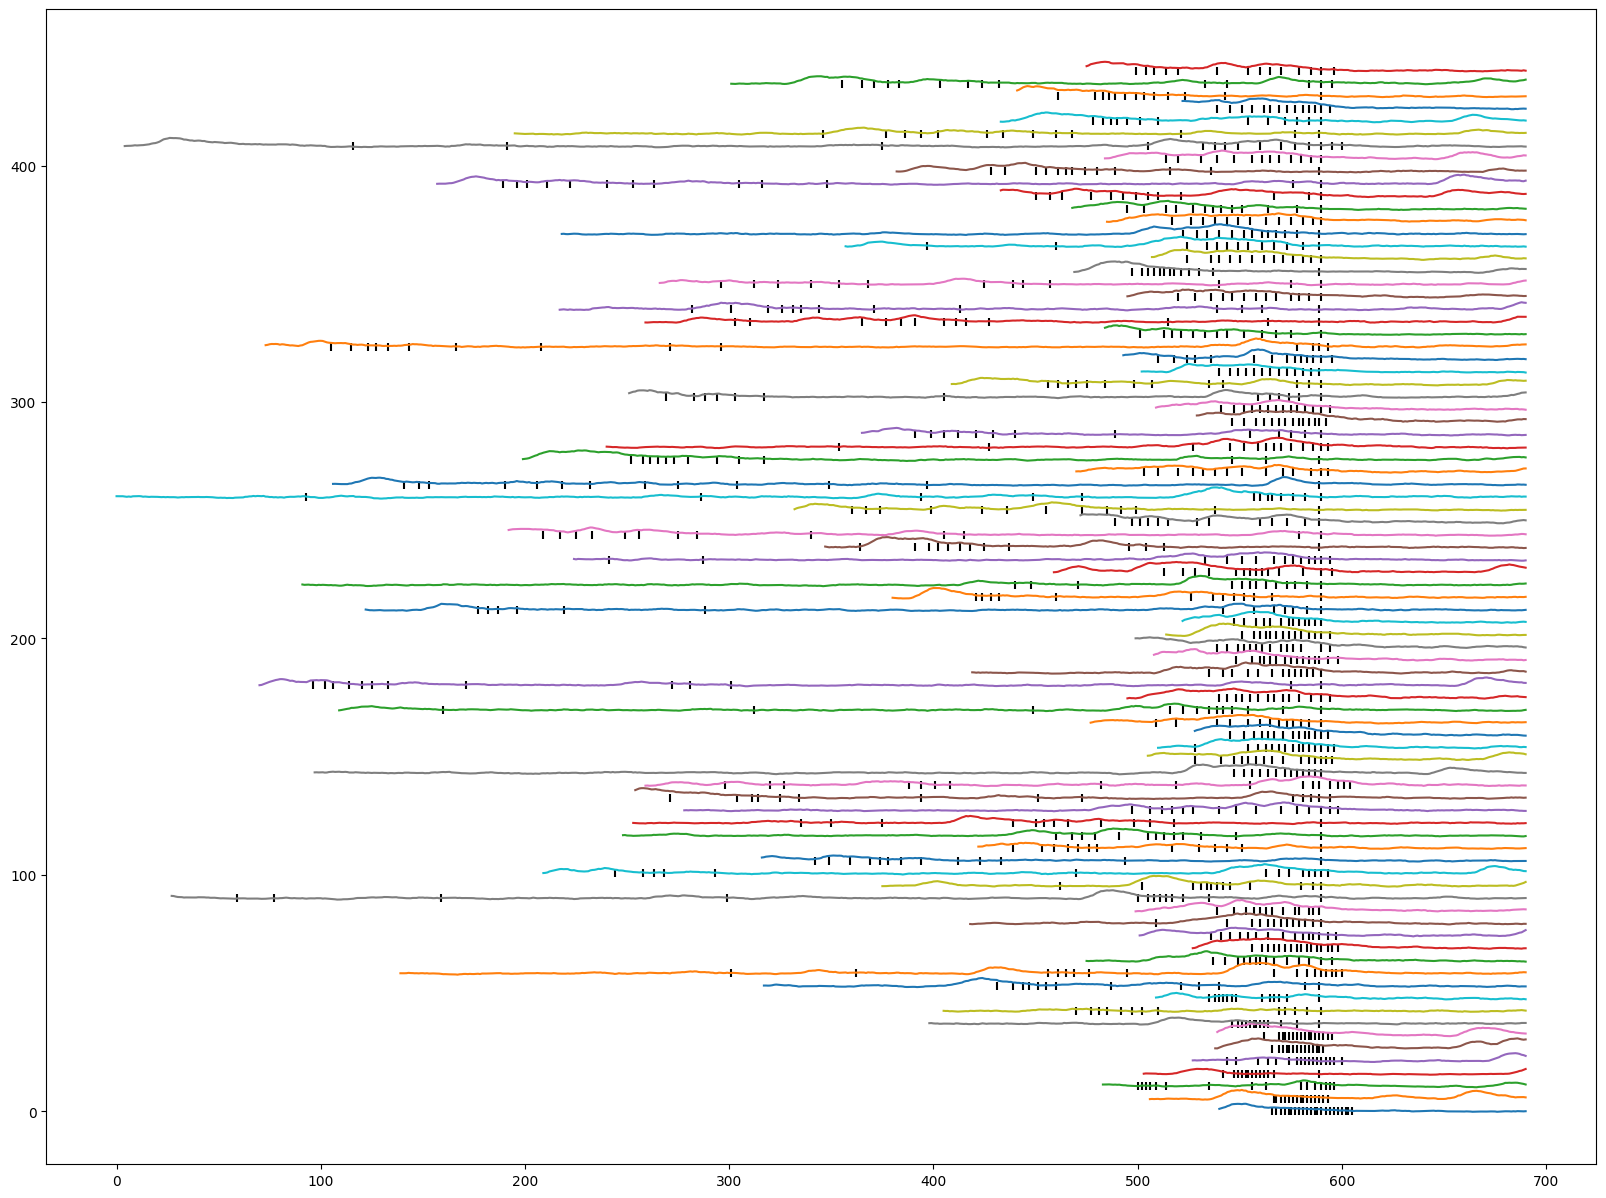

In [78]:
roi_dff_bci_alignon_thr = dff_bci_alignon_thr[i_roi]
max_act = np.nanmax(roi_dff_bci_alignon_thr)
ntrials = roi_dff_bci_alignon_thr.shape[0]
roi_dff_bci_alignon_thr = roi_dff_bci_alignon_thr + np.arange(0,ntrials*max_act,max_act).reshape(-1,1)
fig,ax = plt.subplots(figsize=(20,15))
_=plt.plot(roi_dff_bci_alignon_thr[:,:frames_before+100].T)
_=plt.scatter(zaber_steps-shifts.reshape(-1,1).astype(int),np.zeros(zaber_steps.shape)+np.arange(0,ntrials*max_act,max_act).reshape(-1,1),color='k',marker='|')

In [79]:
from scipy.signal import find_peaks
find_peaks(smooth_dff_valid[i_roi, idxstart:idxend], height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)

(array([  5,   9,  12,  28,  32,  37,  39,  43,  46,  48,  52,  54,  59,
         66,  70,  77,  80,  83,  86,  89,  91,  97, 102, 107, 111, 113,
        119, 123, 126, 131, 134, 139, 143, 152, 156, 159, 161, 166, 168,
        173, 175, 177, 180, 184, 189, 192, 196, 201, 216, 221, 224, 229,
        235, 237, 241, 246, 249, 254, 257, 260, 263, 265, 269, 271, 274,
        278, 282, 286, 290, 293, 298, 300, 304, 308, 311, 329, 331, 336,
        340, 343, 345, 348, 351, 353, 357, 359, 362, 365, 368, 373, 376,
        380, 382, 384, 387, 391, 397, 400, 402, 404, 411, 415, 419, 423,
        430, 433, 436, 440, 444, 447, 449, 452, 456, 460, 467, 473, 476,
        481, 484, 488, 502, 504, 506, 511, 513, 518, 520, 523, 526, 531,
        534, 539, 542, 545, 551, 555, 557, 563, 566, 571, 575, 577, 580,
        584, 588, 597, 600, 606, 609, 612, 616, 621, 624, 626, 628, 632,
        634]),
 {})

Text(0.5, 0, 'Time (s)')

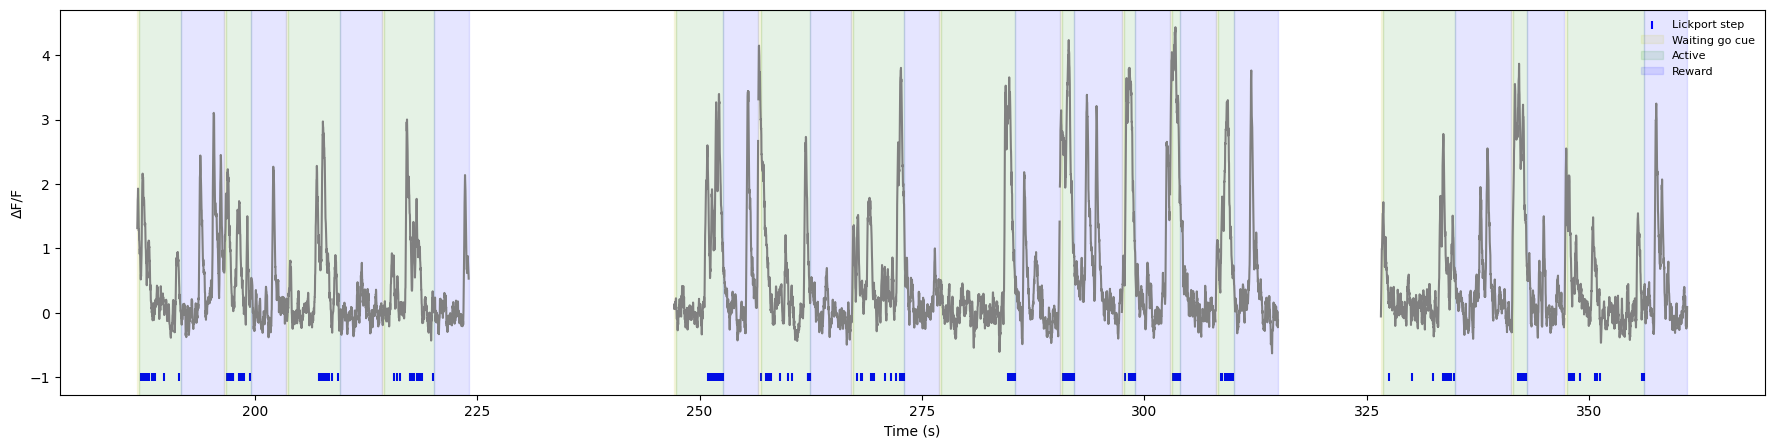

In [82]:
dff_bci_validfig,ax=plt.subplots(figsize=(22,5))
for itr in start_bci_trial.index[20:35]:
    idxstart= start_bci_trial[itr]
    idxend = stop_bci_trial[itr]
    time = np.arange(idxstart,idxend)/frame_rate
    ax.plot(time,smooth_dff_valid[i_roi, idxstart:idxend],'grey')
    ax.scatter((zaber_steps[itr]+idxstart)/frame_rate,-np.ones(len(zaber_steps[itr])),color='b',marker='|', label='Lickport step')

    ax.axvspan(xmin=(idxstart)/frame_rate, xmax=(go_cue_bci[itr]+idxstart)/frame_rate, color='y', alpha=0.1, label = 'Waiting go cue')
    ax.axvspan(xmin=(go_cue_bci[itr]+idxstart)/frame_rate, xmax=(reward_time[itr]+idxstart)/frame_rate, color='g', alpha=0.1, label = 'Active')
    ax.axvspan(xmin=(reward_time[itr]+idxstart)/frame_rate, xmax=(idxend)/frame_rate, color='b', alpha=0.1, label = 'Reward')

handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(),
          fontsize=8, loc='upper right', frameon=False)
#ax.hlines(1.8,224,234)
ax.set_ylabel('ΔF/F')
ax.set_xlabel('Time (s)')
